In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report, 
    roc_curve, auc, confusion_matrix, precision_recall_fscore_support, 
    ConfusionMatrixDisplay
)
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall
from sklearn.preprocessing import label_binarize

### Data

Simulamos un dataset para clasificar entre 3 clases.

In [2]:
X, y = make_classification(
    n_samples=20_000, n_features=4, n_informative=4, n_redundant=0, n_classes=3,
	n_clusters_per_class=1, weights=[0.6, 0.1, 0.3], flip_y=0.05, class_sep=0.8, 
    random_state=18)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=33)

### Modelo

Usamos un clasificador LightGBM.

Ponderamos a las clases según su frecuencia en la función de costos, de modo tal que cada una tenga el mismo peso.

`objective="multiclass"` entrena un clasificador por clase y combina las predicciones con una función softmax. Esta es una estrategia bastante genérica que se conoce como "One-vs-All" o "One-vs-Rest".

En general existen distintas estrategias de entrenar clasificadores multi-clase y las posibilidades dependen de cada modelo específico. Ver por ejemplo [este post de sklearn](https://scikit-learn.org/stable/modules/multiclass.html). 

In [25]:
pd.Series(y).value_counts(normalize=True)

0    0.58685
2    0.30130
1    0.11185
dtype: float64

In [4]:
clf = LGBMClassifier(
    objective="multiclass", class_weight='balanced', n_jobs=2, random_state=99)

In [5]:
%%time
_ = clf.fit(X_train, y_train)

Wall time: 504 ms


In [6]:
y_pred_proba = clf.predict_proba(X_val)
y_pred = y_pred_proba.argmax(axis=1)

In [7]:
print(y_pred_proba[:2])
print(y_pred_proba[:2].sum(axis=1))

[[0.01101852 0.04790754 0.94107394]
 [0.68430199 0.30955272 0.0061453 ]]
[1. 1.]


In [8]:
y_pred[:2]

array([2, 0], dtype=int64)

### Métricas

Vamos a suponer que nuestra métrica objetivo es el F1. Sabemos cómo calcularlo para un problema de clasificación binaria. ¿Cómo podemos extenderlo a un problema de clasificación multiclase?

In [9]:
def binary_confusion_matrix(y_true, y_pred, label):
    y_true_ = y_true == label
    y_pred_ = y_pred == label 
    plot_confusion_matrix(y_true_, y_pred_)
    plt.xlabel(f"Predicted {label}")
    plt.ylabel(f"True {label}")
    plt.title(f"Confusion Matrix for {label}")


def pooled_confusion_matrix(y_true, y_pred):
    # empty confusion matrix
    pooled_cm = np.zeros((2, 2), dtype=int)
    for label in np.unique(y_true):
        y_true_ = y_true == label
        y_pred_ = y_pred == label
        cm = confusion_matrix(y_true_, y_pred_)
        pooled_cm += cm
    disp = ConfusionMatrixDisplay(pooled_cm)
    disp.plot()

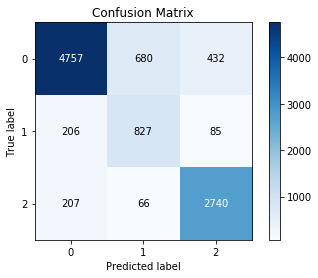

In [10]:
# matriz general
plot_confusion_matrix(y_val, y_pred)
plt.show()

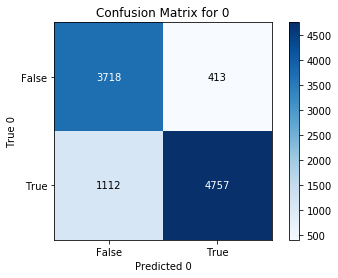

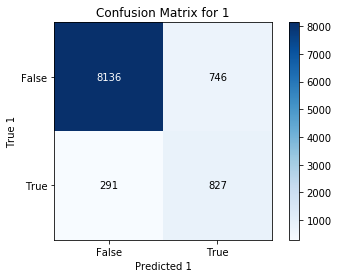

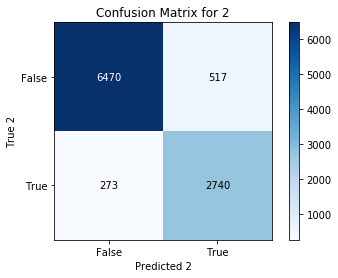

In [11]:
# matrix por clase
for i in range(y_pred_proba.shape[1]):
    binary_confusion_matrix(y_val, y_pred, i)
    plt.show()

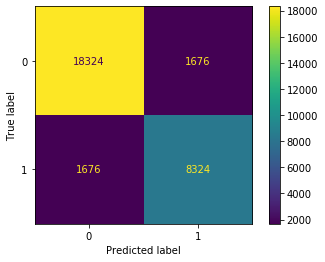

In [12]:
pooled_confusion_matrix(y_val, y_pred)

Existen dos maneras generales de combinar las métricas de cada clase:

* **macro-averaging**: se computa la métrica por clase y se toma el promedio simple
* **micro-averaging**: se computan los falsos y verdaderos positivos y negativos __totales__ y se computa la métrica

Como vemos, la matriz de confusión "pooled" siempre es simétrica! 

Esto es porque los falsos negativos de una clase son necesariamente los falsos positivos desde alguna de las otras clases. Ejemplo: 

$y_i = 1$ 

$y_i^{pred} = 2$

* CM Clase 0 --> True Negative
* CM Clase 1 --> False Negative
* CM Clase 2 --> False Positive

Cuando usamos micro-averaging, esencialmente estamos computando la proporción de observaciones correctamente clasificadas. 

Por eso se cumple que $\text{micro-F1} = \text{micro-precision} = \text{micro-recall} = \text{accuracy}$.

In [13]:
precision_recall_fscore_support(y_val, y_pred, average='micro')

(0.8324, 0.8324, 0.8324, None)

In [14]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      5869
           1       0.53      0.74      0.61      1118
           2       0.84      0.91      0.87      3013

    accuracy                           0.83     10000
   macro avg       0.76      0.82      0.78     10000
weighted avg       0.85      0.83      0.84     10000



Una forma de agregación alternativa es el **macro-weighted average**, que consiste en ponderar las métricas por su soporte (frecuencia).

#### Métricas globales

Para AUROC, podemos calcular una versión "one-vs-rest" (OVR) por clase, usando el score de cada clase y "binarizando" el vector de target:

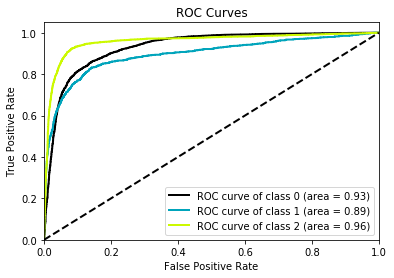

In [15]:
plot_roc(y_val, y_pred_proba, plot_micro=False, plot_macro=False)
plt.show()

Las métricas por clase se pueden combinar con distintos tipos de averaging (micro, macro o weighted):

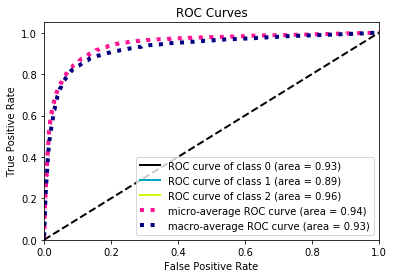

In [16]:
ax = plot_roc(y_val, y_pred_proba)
for i in range(y_pred_proba.shape[1]):
    ax.lines[0].remove()
plt.show()

In [17]:
def auroc_ovr_micro(y_true, y_pred):
    """Version interna de scikit-plot. USE WITH CARE!
    """
    binarized_y = label_binarize(y_true, classes=np.unique(y_true))
    fpr, tpr, _ = roc_curve(binarized_y.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [18]:
print(f"AUROC ovr macro = {roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='macro'):.4f}")
print(f"AUROC ovr weighted = {roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='weighted'):.4f}")
print(f"AUROC ovr micro = {auroc_ovr_micro(y_val, y_pred_proba):.4f}")

AUROC ovr macro = 0.9277
AUROC ovr weighted = 0.9348
AUROC ovr micro = 0.9442


También existen versiones que toman promedios de AUROCs "one-vs-one" (OVO) por clase. En general la versión OVO + weighted se considera un buen default. Sugerimos leer:

* https://scikit-learn.org/stable/modules/model_evaluation.html#multi-class-case
* https://yardstick.tidymodels.org/articles/multiclass.html

In [19]:
print(f"AUROC ovo weighted = {roc_auc_score(y_val, y_pred_proba, multi_class='ovo', average='weighted'):.4f}")

AUROC ovo weighted = 0.9255


También hay maneras diversas de promediar el AUPRC. Sugerimos considerar las versiones macro y weighted como en [`yardstick`](https://yardstick.tidymodels.org/reference/pr_auc.html#multiclass).

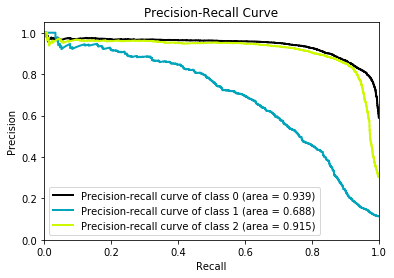

In [20]:
plot_precision_recall(y_val, y_pred_proba, plot_micro=False)
plt.show()

In [21]:
def auc_pr(y_true, y_pred, average="macro"):
    binarized_y = label_binarize(y_true, classes=np.unique(y_true))
    scores = []
    for i in range(y_pred.shape[1]):
        score_ =  average_precision_score(binarized_y[:, i], y_pred[:, i])
        scores.append(score_)
    if average == "macro":
        weights = np.array([1, 1, 1])
    elif average == "weighted":
        weights = np.sum(binarized_y, axis=0)
    return np.average(scores, weights=weights)    

In [22]:
print(f"AUPRC macro = {auc_pr(y_val, y_pred_proba, average='macro'):.4f}")
print(f"AUPRC weighted = {auc_pr(y_val, y_pred_proba, average='weighted'):.4f}")

AUPRC macro = 0.8473
AUPRC weighted = 0.9039


----------------------------------